# Flocks, Herds, and Traffic Jams

Code examples from [Think Complexity, 2nd edition](https://thinkcomplex.com).

Copyright 2016 Allen Downey, [MIT License](http://opensource.org/licenses/MIT)

In [1]:
import matplotlib.pyplot as plt
import numpy as np

In [2]:
from os.path import basename, exists

def download(url):
    filename = basename(url)
    if not exists(filename):
        from urllib.request import urlretrieve
        local, _ = urlretrieve(url, filename)
        print('Downloaded ' + local)
    
download('https://github.com/AllenDowney/ThinkComplexity2/raw/master/notebooks/utils.py')
download('https://github.com/AllenDowney/ThinkComplexity2/raw/master/notebooks/Cell2D.py')

In [3]:
from utils import decorate, savefig
# make a directory for figures
!mkdir -p figs

## Traffic jam

Here's the `Driver` class from Chapter 10.

In [4]:
class Driver:
    
    def __init__(self, loc, speed=4):
        """Initialize the attributes.
        
        loc: position on track, in miles
        speed: speed in miles per hour
        """
        self.start = loc
        self.loc = loc
        self.speed = speed
        
    def choose_acceleration(self, dist):
        """Chooses acceleration based on distance.
        
        dist: distance from the car in front
        
        returns: acceleration
        """
        return 1
        
    def set_odometer(self):
        self.start = self.loc
        
    def read_odometer(self):
        return self.loc - self.start

And the Highway.

In [5]:
from Cell2D import Cell2D

class Highway(Cell2D):
    
    max_acc = 1
    min_acc = -10
    speed_limit = 40
    
    def __init__(self, n=10, length=1000, eps=0, constructor=Driver):
        """Initializes the attributes.
        
        n: number of drivers
        length: length of the track
        eps: variability in speed
        constructor: function used to instantiate drivers
        """
        self.length = length
        self.eps = eps
        self.crashes = 0

        # create the drivers
        locs = np.linspace(0, length, n, endpoint=False)
        self.drivers = [constructor(loc) for loc in locs]
        
        # and link them up
        for i in range(n):
            j = (i+1) % n
            self.drivers[i].next = self.drivers[j]
            
    def step(self):
        """Performs one time step."""
        for driver in self.drivers:
            self.move(driver)
            
    def move(self, driver):
        """Updates `driver`.
        
        driver: Driver object
        """
        # get the distance to the next driver
        dist = self.distance(driver)

        # let the driver choose acceleration
        acc = driver.choose_acceleration(dist)
        acc = min(acc, self.max_acc)
        acc = max(acc, self.min_acc)
        speed = driver.speed + acc
            
        # add random noise to speed
        speed *= np.random.uniform(1-self.eps, 1+self.eps)
        
        # keep it nonnegative and under the speed limit
        speed = max(speed, 0)
        speed = min(speed, self.speed_limit)
        
        # if current speed would collide with next driver, stop
        if speed > dist:
            speed = 0
            self.crashes += 1
            
        # update speed and loc
        driver.speed = speed
        driver.loc += speed
            
    def distance(self, driver):
        """Distance from `driver` to next driver.
        
        driver: Driver object
        """
        dist = driver.next.loc - driver.loc
        # fix wraparound
        if dist < 0:
            dist += self.length
        return dist
    
    def set_odometers(self):
        return [driver.set_odometer()
                for driver in self.drivers] 
    
    def read_odometers(self):
        return np.mean([driver.read_odometer()
                        for driver in self.drivers])
    
    def draw(self):
        """Draws the drivers and shows collisions.
        """
        drivers = self.drivers
        xs, ys = self.get_coords(drivers)
        plt.plot(xs, ys, 'bs', markersize=10, alpha=0.7)
        
        stopped = [driver for driver in self.drivers 
                  if driver.speed==0]
        xs, ys = self.get_coords(stopped, r=0.8)
        plt.plot(xs, ys, 'r^', markersize=12, alpha=0.7)
        
        plt.axis('off')
        plt.axis('equal')
        plt.xlim([-1.05, 1.05])
        plt.ylim([-1.05, 1.05])

    def get_coords(self, drivers, r=1):
        """Gets the coordinates of the drivers.
        
        Transforms from (row, col) to (x, y).
        
        drivers: sequence of Driver
        r: radius of the circle
        
        returns: tuple of sequences, (xs, ys)
        """
        locs = np.array([driver.loc for driver in drivers])
        locs *= 2 * np.pi / self.length
        xs = r * np.cos(locs)
        ys = r * np.sin(locs)
        return xs, ys

Make the animation:

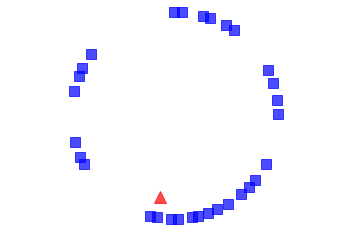

In [6]:
highway = Highway(30, eps=0.02)
highway.animate(frames=50, interval=0.2)

And generate the figure:

Saving figure to file figs/chap10-1


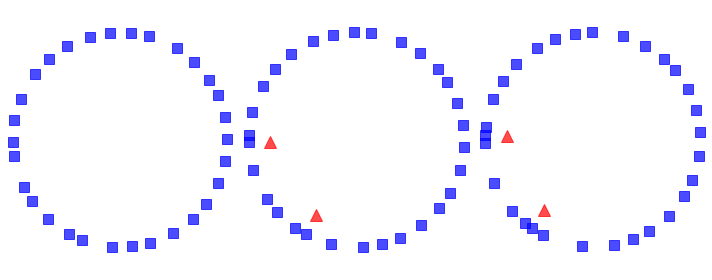

In [7]:
from utils import three_frame

highway = Highway(30, eps=0.02)
three_frame(highway, [16, 1, 1], seed=22)
savefig('figs/chap10-1')

Explore the relationship between `eps` and average speed.

In [8]:
def run_simulation(eps, constructor=Driver, iters=100):
    res = []
    for n in range(5, 100, 5):
        highway = Highway(n, eps=eps, constructor=constructor)
        for i in range(iters):
            highway.step()

        highway.set_odometers()
        for i in range(iters):
            highway.step()

        res.append((n, highway.read_odometers() / iters))
    
    return np.transpose(res)

Generate the figure:

Saving figure to file figs/chap10-2


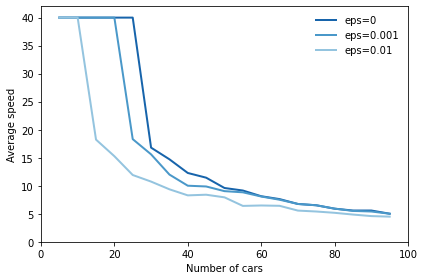

In [9]:
np.random.seed(20)
from utils import set_palette
set_palette('Blues', 4, reverse=True)

for eps in [0.0, 0.001, 0.01]:
    xs, ys = run_simulation(eps)
    plt.plot(xs, ys, label='eps=%g' % eps)
    
decorate(xlabel='Number of cars',
                 ylabel='Average speed',
                 xlim=[0, 100], ylim=[0, 42])

savefig('figs/chap10-2')

**Exercise:** In the traffic jam simulation, define a class, `BetterDriver`,
that inherits from `Driver` and overrides `choose_acceleration`.
See if you can define driving rules that do better than the basic
implementation in `Driver`.  You might try to achieve higher
average speed, or a lower number of collisions.

Here's a first attempt:

In [38]:
class BetterDriver(Driver):
    
    def choose_acceleration(self, dist):
        if self.speed >= 45:
            return 0
        else:
            return (dist - self.speed)

The following loop runs simulations with `Driver` and `BetterDriver`, and plots average speed as a function of the number of cars.

And it prints the area under the curves as one way (but certainly not the only way) to quantify the effect of driving behavior on average speed over the range of densities.

Driver 1512.925
BetterDriver 2164.420161552775


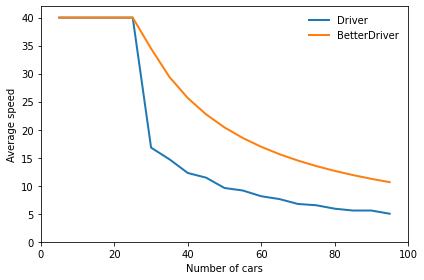

In [39]:
from scipy.integrate import trapezoid

for constructor in [Driver, BetterDriver]:
    xs, ys = run_simulation(eps=0.0, constructor=constructor)
    plt.plot(xs, ys, label=constructor.__name__)
    print(constructor.__name__, trapezoid(ys, xs))
    
decorate(xlabel='Number of cars',
                 ylabel='Average speed',
                 xlim=[0, 100], ylim=[0, 42])

`BetterDriver` is a little better in the sense that it keeps traffic moving smoothly at medium densities. However:

* At high densities, it has almost no effect, and

* At low densities, it is substantially worse.

As a result, the total are under the curve is much less.

See if you can write rules for the agents that maximize the area under the curve.